In [1]:
import pandas as pd
df = pd.read_excel('histories_room_ota2.xlsx')
df

,Hotel Name,OTA,Room Name,Date,Price,Unnamed: 5
0,Hotel Santika Premiere Jogja,booking,Deluxe Twin Room,2023-01-26 00:00:00,1150000,NaN
1,Yogyakarta Marriott Hotel,booking,"Guest room, 2 Double, City view",2023-01-26 00:00:00,2223980,NaN
2,Yogyakarta Marriott Hotel,booking,"Guest room, 2 Double, Pool view",2023-01-26 00:00:00,2526480,NaN
3,Yogyakarta Marriott Hotel,booking,"M Club lounge access, 1 Bed Room Executive Sui...",2023-01-26 00:00:00,4719000,NaN
4,Yogyakarta Marriott Hotel,booking,"M Club lounge access, Guest room, 2 Double, Ci...",2023-01-26 00:00:00,2722500,NaN
...,...,...,...,...,...,...
368733,Horison Ultima Makassar,tiket,Kamar Deluks Twin,2023-01-24 00:00:00,479999,NaN
368734,Horison Ultima Makassar,tiket,Kamar Superior Twin,2023-01-24 00:00:00,449999,NaN
368735,Horison Ultima Makassar,tiket,Suite Eksekutif King dengan Pemandangan Kota,2023-01-24 00:00:00,2555555,NaN
368736,Horison Ultima Makassar,tiket,Suite Junior Double,2023-01-24 00:00:00,1499999,NaN


In [2]:
from predict_price_clean import *
model = PriceForecast()

date = df['Date']
price = df['Price']
hotel_name = df['Hotel Name']
room_name = df['Room Name']
ota = df['OTA']
model.initialize_data(date,price, hotel_name, room_name, ota)


,date,price,hotel_name,room_name,ota
0,2023-01-26 00:00:00,1150000,Hotel Santika Premiere Jogja,Deluxe Twin Room,booking
1,2023-01-26 00:00:00,2223980,Yogyakarta Marriott Hotel,"Guest room, 2 Double, City view",booking
2,2023-01-26 00:00:00,2526480,Yogyakarta Marriott Hotel,"Guest room, 2 Double, Pool view",booking
3,2023-01-26 00:00:00,4719000,Yogyakarta Marriott Hotel,"M Club lounge access, 1 Bed Room Executive Sui...",booking
4,2023-01-26 00:00:00,2722500,Yogyakarta Marriott Hotel,"M Club lounge access, Guest room, 2 Double, Ci...",booking
...,...,...,...,...,...
368733,2023-01-24 00:00:00,479999,Horison Ultima Makassar,Kamar Deluks Twin,tiket
368734,2023-01-24 00:00:00,449999,Horison Ultima Makassar,Kamar Superior Twin,tiket
368735,2023-01-24 00:00:00,2555555,Horison Ultima Makassar,Suite Eksekutif King dengan Pemandangan Kota,tiket
368736,2023-01-24 00:00:00,1499999,Horison Ultima Makassar,Suite Junior Double,tiket


In [3]:
model.read_data('All Nite & Day Hotel Yogyakarta - Gejayan','Day Room','agoda')


,date,price,hotel_name,room_name,ota
83849,2023-04-11 00:00:00,314058,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
84565,2023-04-12 00:00:00,332444,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
85541,2023-04-13 00:00:00,286685,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
86707,2023-04-14 00:00:00,326655,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
88016,2023-04-15 00:00:00,329113,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
...,...,...,...,...,...
363345,2023-10-02 00:00:00,350161,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
364744,2023-10-03 00:00:00,393736,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
366042,2023-10-04 00:00:00,370456,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda
367157,2023-10-05 00:00:00,376655,All Nite & Day Hotel Yogyakarta - Gejayan,Day Room,agoda


In [4]:
model.model_predict()

d:\dev\Rekomendasi harga Robota\dev\predict_price_clean.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['price'] = pd.to_numeric(train['price'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=2174.571, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2186.961, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2178.977, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2177.321, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2184.971, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=2172.944, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=2185.827, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=2174.710, Time=0.22 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=2177.045, Time=0.18 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=2175.666, Time=0.47 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=2170.737, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=2183.532, Time=0.07 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=2172.379, Time=0.16 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=2172.511, Time=0.22 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,date,price,lower price,upper price
179,2023-10-07,381552.315129,296703.842826,466400.787431
180,2023-10-08,364810.779161,255459.994103,474161.564218
181,2023-10-09,367308.112657,251525.899052,483090.326262
182,2023-10-10,382478.698149,263550.792147,501406.604152
183,2023-10-11,375266.157751,253210.041187,497322.274315
184,2023-10-12,377506.366064,252383.972941,502628.759187
185,2023-10-13,374638.145345,246518.699777,502757.590913
186,2023-10-14,373798.979864,234054.854828,513543.104900
187,2023-10-15,373946.261304,225350.394617,522542.127991
188,2023-10-16,374276.201622,220332.350456,528220.052788


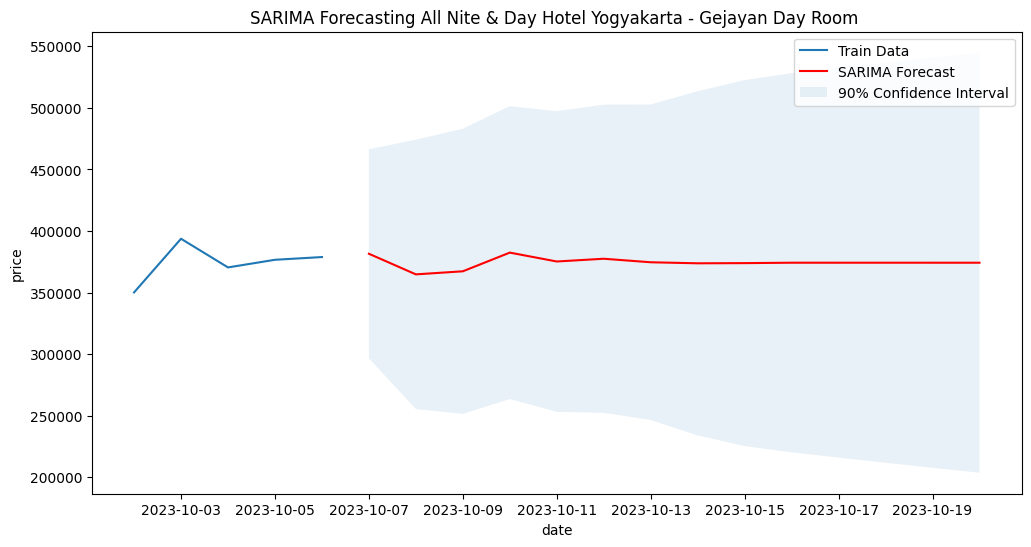

In [5]:
model.plot_prediction()